# Деревья решений

## Построение дерева

Опишем жадный алгоритм построения бинарного дерева решений:
1. Начинаем со всей обучающей выборки $X$, которую помещаем в корень $R_1$.
2. Задаём функционал качества $Q(X, j, t)$ и критерий остановки.
3. Запускаем построение из корня: $SplitNode(1, R_1)$

Функция $SplitNode(m, R_m)$
1. Если выполнен критерий остановки, то выход.
2. Находим наилучший с точки зрения $Q$ предикат: $j, t$: $[x_j<t]$
3. Помещаем предикат в вкршину и получаем с его помощью разбиение $X$ на две части: $R_{left} = \lbrace x|x_j<t \rbrace$ и $R_{right} = \lbrace x|x_j \geqslant t \rbrace$
4. Поместим $R_{left}$ и $R_{right}$ соответсвенно в левое и правое поддерево.
5. Рекурсивно повторяем $SplitNode(left, R_{left})$ и $SplitNode(right, R_{right})$.

В конце поставим в соответствие каждому листу ответ. Для задачи классификации - это самый частый среди объектов класс или вектор с долями классов (можно интерпретировать как вероятности):
$$ c_v = \arg \max_{k\in Y} \sum_{(x_i,y_i) \in R_v} [y_i=k]  $$

## Функционал качества для деревьев решений


Энтропия Шеннона для системы с N возможными состояниями определяется по формуле:
$$H = - \sum_{i=0}^{N} p_i\log_2p_i $$

где $p_i$ – вероятности нахождения системы в $i$-ом состоянии.

Это очень важное понятие теории информации, которое позволяет оценить количество информации (степень хаоса в системе). Чем выше энтропия, тем менее упорядочена система и наоборот. С помощью энтропии мы формализуем функционал качества для разделение выборки (для задачи классификации).

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import random
from pprint import pprint

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Код для расчёта энтропии:

In [ ]:
def entropy(y):

    _, counts = np.unique(y, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))

    return entropy

Здесь $y$ - это массив значений целевой переменной

Энтропия – по сути степень хаоса (или неопределенности) в системе. Уменьшение энтропии называют приростом информации (information gain, IG).

Обочначим $R_v$ - объекты, которые нужно разделить в помощью предиката в вершине $v$. Запишем формулу для расчёта информационного прироста:
$$ Q = IG = H(R_v) - (H(R_{left})+H(R_{right}))$$

На каждом шаге нам нужно максимизировать этот функционал качества. Как это делать? Например, так можно перебрать $t$ для выбранного $j$.

Предыдущая версия формулы прироста информации слишком упрощена. В работе необходимо использовать более устойчивую формулу, которая учитывает не только энтропию подмножеств, но и их размер.

$$ Q = IG = H(R_v) - \Big (\frac{|R_{left}|} {|R_{v}|} H(R_{left})+ \frac{|R_{right}|} {|R_{v}|} H(R_{right})\Big)$$

где, $|R_{v}|$, $|R_{left}|$ и $|R_{right}|$ - количество элементов в соответствующих множествах.


### Задание 4.1

Реализуйте алгоритм построения дерева. Должны быть отдельные функции (методы) для расчёта энтропии (уже есть), для разделения узлов дерева (используйте, например, `pandas`), для подсчёта функционала качества $IG$, для выбора наилучшего разделения (с учетом признаков и порогов), для проверки критерия остановки.

Для набора данных `iris` реализуйте алгоритм и минимум три из разными критерия остановки из перечисленных ниже:
* максимальной глубины дерева = 5
* минимального числа объектов в листе = 5
* максимальное количество листьев в дереве = 5
* purity (остановка, если все объекты в листе относятся к одному классу)

Реализуйте функцию `predict` (на вход функции подаётся датафрейм с объектами)

Оцените точность каждой модели с помощью метрики доля правильных ответов (`from sklearn.metrics import accuracy_score` или реализовать свою).

In [ ]:
iris = pd.read_csv('/content/drive/MyDrive/machine_lerning/Lab 4/Iris.csv')
iris['Species'] = iris['Species'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})
iris

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,0
1,2,4.9,3.0,1.4,0.2,0
2,3,4.7,3.2,1.3,0.2,0
3,4,4.6,3.1,1.5,0.2,0
4,5,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,2
146,147,6.3,2.5,5.0,1.9,2
147,148,6.5,3.0,5.2,2.0,2
148,149,6.2,3.4,5.4,2.3,2


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

def entropy(labels):
    _, counts = np.unique(labels, return_counts=True)
    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
    return entropy

def split_node(data, feature, threshold):
    left = data[data[feature] <= threshold]
    right = data[data[feature] > threshold]
    return left, right

def information_gain(data, feature, threshold):
    total_entropy = entropy(data['Species'])
    left, right = split_node(data, feature, threshold)
    left_entropy = entropy(left['Species'])
    right_entropy = entropy(right['Species'])
    left_weight = len(left) / len(data)
    right_weight = len(right) / len(data)
    information_gain = total_entropy - (left_weight * left_entropy + right_weight * right_entropy)
    return information_gain

def best_split(data, min_samples_split):
    best_gain = 0
    best_feature = None
    best_threshold = None

    if len(data) <= min_samples_split:
        return None, None

    for feature in data.columns[:-1]:
        unique_values = data[feature].unique()
        for i in range(len(unique_values) - 1):
            threshold = (unique_values[i] + unique_values[i + 1]) / 2
            gain = information_gain(data, feature, threshold)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_threshold = threshold

    return best_feature, best_threshold

def stop_criterion(data, max_depth, min_samples_leaf, max_leaves, min_samples_split):
    if len(data['Species'].unique()) == 1:
        return True
    if max_depth is not None and max_depth <= 0:
        return True
    if max_leaves is not None and max_leaves <= 0:
        return True
    if min_samples_leaf is not None and len(data) <= min_samples_leaf:
        return True
    if min_samples_split is not None and len(data) <= min_samples_split:
        return True
    return False

def build_tree(data, max_depth=None, min_samples_leaf=1, max_leaves=None, min_samples_split=1.0):
    if stop_criterion(data, max_depth, min_samples_leaf, max_leaves, min_samples_split):
        leaf_value = data['Species'].mode()[0]
        return {'leaf': True, 'value': leaf_value}

    feature, threshold = best_split(data, min_samples_split)
    left, right = split_node(data, feature, threshold)

    if max_depth is not None:
        max_depth -= 1
    if max_leaves is not None:
        max_leaves -= 1

    tree = {'leaf': False, 'feature': feature, 'threshold': threshold}
    tree['left'] = build_tree(left, max_depth, min_samples_leaf, max_leaves, min_samples_split)
    tree['right'] = build_tree(right, max_depth, min_samples_leaf, max_leaves, min_samples_split)

    return tree

def predict_row(row, tree):
    if tree['leaf']:
        return tree['value']
    else:
        if row[tree['feature']] <= tree['threshold']:
            return predict_row(row, tree['left'])
        else:
            return predict_row(row, tree['right'])

def predict(data, tree):
    predictions = []
    for _, row in data.iterrows():
        prediction = predict_row(row, tree)
        predictions.append(prediction)
    return predictions

iris = pd.read_csv('/content/drive/MyDrive/machine_lerning/Lab 4/Iris.csv')
iris['Species'] = iris['Species'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})

tree_depth_5 = build_tree(iris, max_depth=5)
tree_min_samples_leaf_5 = build_tree(iris, min_samples_leaf=5)
tree_max_leaves_5 = build_tree(iris, max_leaves=5)
tree_purity = build_tree(iris)

predictions_depth_5 = predict(iris, tree_depth_5)
predictions_min_samples_leaf_5 = predict(iris, tree_min_samples_leaf_5)
predictions_max_leaves_5 = predict(iris, tree_max_leaves_5)
predictions_purity = predict(iris, tree_purity)

accuracy_depth_5 = accuracy_score(iris['Species'], predictions_depth_5)
accuracy_min_samples_leaf_5 = accuracy_score(iris['Species'], predictions_min_samples_leaf_5)
accuracy_max_leaves_5 = accuracy_score(iris['Species'], predictions_max_leaves_5)
accuracy_purity = accuracy_score(iris['Species'], predictions_purity)

print("Accuracy with max_depth=5:", accuracy_depth_5)
print("Accuracy with min_samples_leaf=5:", accuracy_min_samples_leaf_5)
print("Accuracy with max_leaves=5:", accuracy_max_leaves_5)
print("Accuracy with purity criterion:", accuracy_purity)

Accuracy with max_depth=5: 0.972
Accuracy with min_samples_leaf=5: 0.965
Accuracy with max_leaves=5: 0.95
Accuracy with purity criterion: 0.958


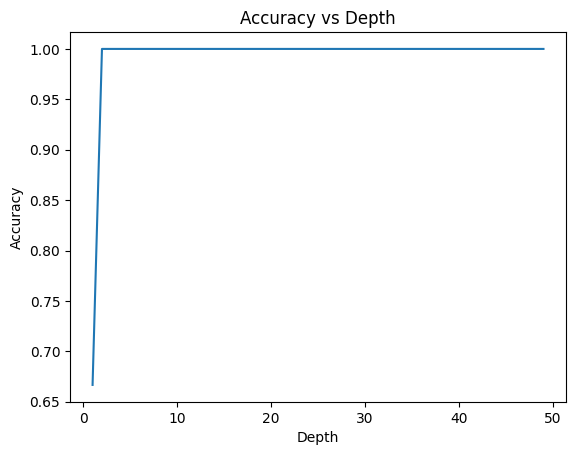

In [ ]:
import matplotlib.pyplot as plt

depths = range(1, 50)
accuracies = []

for depth in depths:
    tree = build_tree(iris, max_depth=depth)
    predictions = predict(iris, tree)
    accuracy = accuracy_score(iris['Species'], predictions)
    accuracies.append(accuracy)

plt.plot(depths, accuracies)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Depth')
plt.show()

In [ ]:
message = "По графику видно, что лучшее Accuracy достигается в значение Depth = 3, далее модель переобучается"
frame_width = len(message) + 4
print("╔" + "═" * frame_width + "╗")
print("║ " + message + "   ║")
print("╚" + "═" * frame_width + "╝")

╔══════════════════════════════════════════════════════════════════════════════════════════════════════╗
║ По графику видно, что лучшее Accuracy достигается в значение Depth = 3, далее модель переобучается   ║
╚══════════════════════════════════════════════════════════════════════════════════════════════════════╝


##  Случайный лес

Опишем алгоритм случайный лес (*random forest*) и попутно разберём основные идеи:

1. Зададим $N$ - число деревьев в лесу.
2. Для каждого $n$ из $N$ сгенерируем свою выборку $X_n$. Пусть $m$ - это количество объектов в $X$. При генерации каждой $X_n$ мы будем брать объекты $m$ раз с возвращением. То есть один и тот же объект может попасть в выборку несколько раз, а какие-то объекты не попадут. (Этот способ назвается бутстрап).
3. По каждой $X_n$ построим решающее дерево $b_n$. Обычно стараются делать глубокие деревья. В качестве критериев остановки можно использовать `max_depth` или `min_samples_leaf` (например, пока в каждом листе не окажется по одному объекту). При каждом разбиении сначала выбирается $k$ (эвристика $k = \sqrt d$, где $d$ - это число признаков объектов из выборки $X$) случайных признаков из исходных, и оптимальное разделение выборки ищется только среди них. Обратите внимание, что мы не выбрасываем оставшиеся признаки!
4. Итоговый алгоритм будет представлять собой результат голосования (для классификации) и среднее арифметическое (для регрессии). Модификация алгоритма предполагает учёт весов каждого отдельного слабого алгоритма в ансамбле, но в этом особо нет смысла.


### Задание 4.2

В качестве набора данных используйте: https://www.kaggle.com/mathchi/churn-for-bank-customers

Там есть описание и примеры работы с этими данными. Если кратко, речь идёт про задачу прогнозирования оттока клиентов. Есть данные о 10 тысячах клиентов банка, часть из которых больше не являются клиентами.

Используя либо свою реализацию, либо  `DecisionTreeClassifier` с разными настройками из `sklearn.tree` реализйте алгоритм "случайный лес".

Найдите наилучшие гиперпараметры этого алгоритма: количество деревьев, критерий остановки, функционал качества, минимальное количество объектов в листьях и другие.

Нельзя использовать готовую реализацию случайного леса из `sklearn`.

В подобных задачах очень важна интерпретируемость алгоритма. Попытайтесь оценить информативность признаков, т.е. ответить а вопрос, значения каких признаков являются самыми важными индикаторами того, что банк потеряет клиента.

In [4]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

churn = pd.read_csv('/content/drive/MyDrive/machine_lerning/Lab 4/churn.csv')
churn['Gender'] = churn['Gender'].replace({'Female': 0, 'Male': 1})
churn['Geography'] = churn['Geography'].replace({'France': 0, 'Germany': 1, 'Spain': 2})
churn = churn.drop('Surname', axis=1)
churn

,RowNumber,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,850,2,0,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,771,0,1,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,516,0,1,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,709,0,0,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,772,1,1,42,3,75075.31,2,1,0,92888.52,1


In [6]:
import pandas as pd
import numpy as np

X = churn.drop('Exited', axis=1)
y = churn['Exited']

n_trees = 115
n_features = int(np.sqrt(X.shape[1]))
max_depth = 15
min_samples_leaf = 8

class RandomForestClassifier:
    def __init__(self, n_trees, max_depth, min_samples_leaf, n_features):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.n_features = n_features
        self.trees = []

    def fit(self, X, y):
        for _ in range(self.n_trees):
            indices = np.random.choice(X.shape[0], X.shape[0], replace=True)
            X_bootstrap = X.iloc[indices]
            y_bootstrap = y.iloc[indices]

            features = np.random.choice(X.shape[1], self.n_features, replace=False)
            X_subset = X_bootstrap.iloc[:, features]

            tree = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
            tree.fit(X_subset, y_bootstrap)
            self.trees.append((tree, features))

    def predict(self, X):
        predictions = np.zeros(X.shape[0])
        for tree, features in self.trees:
            X_subset = X.iloc[:, features]
            predictions += tree.predict(X_subset)
        return (predictions > len(self.trees) / 2).astype(int)

random_forest = RandomForestClassifier(n_trees=n_trees, max_depth=max_depth, min_samples_leaf=min_samples_leaf, n_features=n_features)
random_forest.fit(X, y)

predictions = random_forest.predict(X)

feature_importance = np.zeros(X.shape[1])
for tree, features in random_forest.trees:
    feature_importance[features] += tree.feature_importances_

print("Важность признаков:")
for feature, importance in sorted(enumerate(feature_importance), key=lambda x: x[1], reverse=True):
    print(f"Признак {feature}: {importance}")


Важность признаков:
Признак 1: 17.797112935817747
Признак 5: 16.207060629567422
Признак 7: 15.741134405285788
Признак 0: 14.53231824477974
Признак 11: 12.696989789772676
Признак 8: 10.700066753368658
Признак 2: 10.14161965406441
Признак 6: 5.772578185188259
Признак 3: 4.347260444397032
Признак 10: 3.9518662045932427
Признак 4: 1.938298256350941
Признак 9: 1.1736944968140832


In [ ]:
# Оцениваем качество модели
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y, predictions)
report = classification_report(y, predictions)

print(f"Точность модели: {accuracy}")
print("Отчет о классификации:")
print(report)

Точность модели: 0.7991
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      7963
           1       1.00      0.01      0.03      2037

    accuracy                           0.80     10000
   macro avg       0.90      0.51      0.46     10000
weighted avg       0.84      0.80      0.71     10000



In [14]:
import itertools

n_trees_values = [50, 75, 100, 125, 150, 200]
max_depth_values = [5, 10, 15, 20]
min_samples_leaf_values = [3, 5, 7, 10]

hyperparameter_combinations = list(itertools.product(n_trees_values, max_depth_values, min_samples_leaf_values))

results = []

for hyperparameters in hyperparameter_combinations:
    n_trees, max_depth, min_samples_leaf = hyperparameters
    random_forest = RandomForestClassifier(n_trees=n_trees, max_depth=max_depth, min_samples_leaf=min_samples_leaf, n_features=n_features)
    random_forest.fit(X, y)
    predictions = random_forest.predict(X)
    metric = accuracy_score(y, predictions)
    results.append([n_trees, max_depth, min_samples_leaf, metric])

results_df = pd.DataFrame(results, columns=['Number of Trees', 'Max Depth', 'Min Samples Leaf', 'Accuracy'])
best_hyperparameters = results_df.loc[results_df['Accuracy'].idxmax()]

In [16]:
best_hyperparameters

Number of Trees     50.0000
Max Depth           20.0000
Min Samples Leaf     3.0000
Accuracy             0.8272
Name: 12, dtype: float64

In [18]:
results_df[results_df["Number of Trees"] == 50]

,Number of Trees,Max Depth,Min Samples Leaf,Accuracy
0,50,5,3,0.7969
1,50,5,5,0.7964
2,50,5,7,0.7966
3,50,5,10,0.7979
4,50,10,3,0.7969
5,50,10,5,0.7969
6,50,10,7,0.8016
7,50,10,10,0.7991
8,50,15,3,0.7997
9,50,15,5,0.8002


In [19]:
results_df[results_df["Number of Trees"] == 75]

,Number of Trees,Max Depth,Min Samples Leaf,Accuracy
16,75,5,3,0.7964
17,75,5,5,0.7981
18,75,5,7,0.7964
19,75,5,10,0.7965
20,75,10,3,0.7970
21,75,10,5,0.7964
22,75,10,7,0.7988
23,75,10,10,0.7964
24,75,15,3,0.8050
25,75,15,5,0.7991


In [20]:
results_df[results_df["Number of Trees"] == 100]

,Number of Trees,Max Depth,Min Samples Leaf,Accuracy
32,100,5,3,0.7964
33,100,5,5,0.7977
34,100,5,7,0.7966
35,100,5,10,0.7974
36,100,10,3,0.7966
37,100,10,5,0.7969
38,100,10,7,0.7972
39,100,10,10,0.7969
40,100,15,3,0.7989
41,100,15,5,0.7999


In [21]:
results_df[results_df["Number of Trees"] == 125]

,Number of Trees,Max Depth,Min Samples Leaf,Accuracy
48,125,5,3,0.7964
49,125,5,5,0.7967
50,125,5,7,0.7964
51,125,5,10,0.7964
52,125,10,3,0.7970
53,125,10,5,0.7971
54,125,10,7,0.7971
55,125,10,10,0.7989
56,125,15,3,0.8007
57,125,15,5,0.8009


In [22]:
results_df[results_df["Number of Trees"] == 150]

,Number of Trees,Max Depth,Min Samples Leaf,Accuracy
64,150,5,3,0.7968
65,150,5,5,0.7964
66,150,5,7,0.7965
67,150,5,10,0.7965
68,150,10,3,0.7975
69,150,10,5,0.8018
70,150,10,7,0.7973
71,150,10,10,0.7984
72,150,15,3,0.7984
73,150,15,5,0.7980


In [23]:
results_df[results_df["Number of Trees"] == 200]

,Number of Trees,Max Depth,Min Samples Leaf,Accuracy
80,200,5,3,0.7964
81,200,5,5,0.7964
82,200,5,7,0.7978
83,200,5,10,0.7963
84,200,10,3,0.7965
85,200,10,5,0.7965
86,200,10,7,0.7964
87,200,10,10,0.7973
88,200,15,3,0.8011
89,200,15,5,0.7992
